# PBL最終課題

In [2]:
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split as tts
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.metrics import r2_score, classification_report
from sklearn.tree import export_graphviz as EG
from pydotplus import graph_from_dot_data as GFDD
from sklearn.preprocessing import StandardScaler
from PIL import Image
from lifelines import CoxPHFitter
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.api as sm

## データの読み込み

In [3]:
df = pd.read_csv("leukemia.csv")
df.head()

,t,status,sex,logWBC,Rx
0,35,0,1,1.45,0
1,34,0,1,1.47,0
2,32,0,1,2.20,0
3,32,0,1,2.53,0
4,25,0,1,1.78,0


## クロス集計表(リスク比)
クロス集計表で投与と効果に関係があるか見る。

ここで性別が関与しているかも確かめる

In [5]:
df_crs = pd.crosstab([df["Rx"], df["sex"]], df["status"])
df_crs

status  0   1
Rx sex       
0  0    6   5
   1    6   4
1  0    0  11
   1    0  10

In [6]:
crs = df_crs.values
risk = [crs[0][1]/sum(crs[0]), crs[1][1]/sum(crs[1]), crs[2][1]/sum(crs[3]), crs[2][1]/sum(crs[3])]
rr = ["", "", risk[2]/risk[0], risk[3]/risk[1]]
rr2 = ["", "", "", rr[3]/rr[2]]
df_risk = pd.DataFrame(risk)
df_risk.columns = ["risk"]
df_rr = pd.DataFrame(rr)
df_rr.columns = ["risk_ratio"]
df_rr2 = pd.DataFrame(rr2)
df_rr2.columns = ["risk_ratio(in sex)"]
df_risk = pd.concat([df_risk, df_rr, df_rr2], axis=1)
df_risk.index = df_crs.index
df_risk = pd.concat([df_crs, df_risk], axis=1)
df_risk

0   1      risk risk_ratio risk_ratio(in sex)
Rx sex                                               
0  0    6   5  0.454545                              
   1    6   4  0.400000                              
1  0    0  11  1.100000       2.42                   
   1    0  10  1.100000       2.75           1.136364

男女とも投与した方が効果は2倍以上違う事が分かる。

また性差はほぼ無い事が分かる。
### カイ二乗検定
上記の結果が有意だったかを検証する。

In [8]:
x2, p, dfv, expected = stats.chi2_contingency(crs)
print("X2:", x2)
print("p-val:", p)
df_ex = pd.DataFrame(expected)
df_ex.index = df_crs.index
df_ex.columns = df_crs.columns
df_ex

X2: 16.876363636363635
p-val: 0.000749348413594645


status         0         1
Rx sex                    
0  0    3.142857  7.857143
   1    2.857143  7.142857
1  0    3.142857  7.857143
   1    2.857143  7.142857

## 目的変数が量的変数で説明変数が質的変数の効果測定(リスク差)
量的変数である目的変数を評価値にして効果測定を行う

In [10]:
def effecttest(df, columns, y_name, auto=True):
    ave = []
    dtr = []
    pos = []
    lab = []
    x = 0
    for col in columns:
        values = list(set(df[col].values))
        tmp_ave = []
        tmp_dtr = []
        tmp_pos = []
        tmp_lab = []
        for val in values:
            df_tmp = df[df[col]==val]
            tmp_ave.append(df_tmp[y_name].mean())
            tmp_dtr.append(df_tmp[y_name])
            tmp_pos.append(x)
            tmp_lab.append(col+"_"+str(val))
            x = x + 1
        ave.append(tmp_ave)
        dtr.append(tmp_dtr)
        pos.append(tmp_pos)
        lab.append(tmp_lab)
    if auto:
        for i in range(len(dtr)):
            for j in range(len(dtr[i])):
                for k in range(j, len(dtr[i])):
                    if j != k:
                        f, p = stats.bartlett(dtr[i][0], dtr[i][1])
                        if (2 * p) <= 0.05:
                            t, p = stats.ttest_ind(dtr[i][j], dtr[i][k], equal_var=False)
                        else:
                            t, p = stats.ttest_ind(dtr[i][j], dtr[i][k], equal_var=True)
                        print(lab[i][j], lab[i][k])
                        print("t   = %f"%(t))
                        print("p   = %f"%(p))
                        print("val = %f"%(ave[i][j]-ave[i][k]))
                        print()
        for i in range(len(dtr)):
            plt.boxplot(dtr[i], positions=pos[i], labels=lab[i])
            plt.plot(pos[i], ave[i], marker="x")
        plt.xticks(rotation=90)
        plt.show()
    return ave, dtr, pos, lab

### 条件なしの比較
単純にデータを比較する

Rx_0 Rx_1
t   = -2.168723
p   = 0.036107
val = -0.588095

status_0 status_1
t   = -3.436990
p   = 0.001386
val = -0.958167

sex_0 sex_1
t   = -0.681453
p   = 0.500781
val = -0.199045



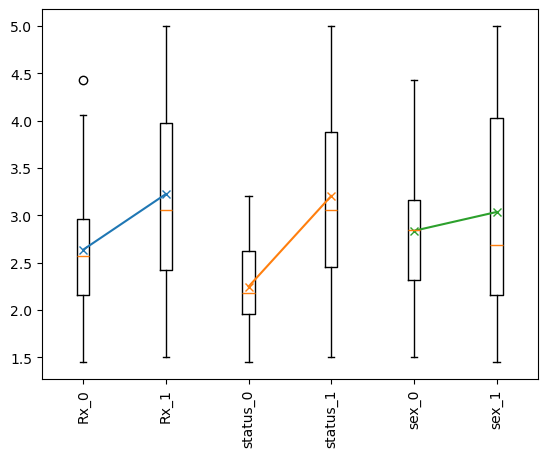

In [12]:
ave, dtr, pos, lab = effecttest(df, ["Rx", "status", "sex"], "logWBC")

### 投与していない場合の比較

status_0 status_1
t   = -3.242351
p   = 0.004287
val = -0.910833

sex_0 sex_1
t   = 1.368048
p   = 0.187260
val = 0.452818



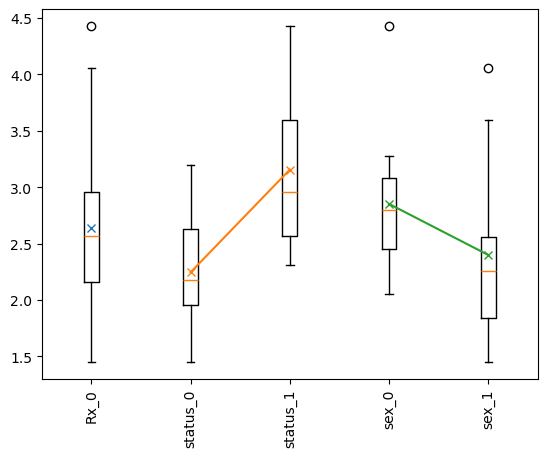

In [14]:
ave, dtr, pos, lab = effecttest(df[df["Rx"]==0], ["Rx", "status", "sex"], "logWBC")

### 投与した場合の比較

sex_0 sex_1
t   = -2.183527
p   = 0.041743
val = -0.850909



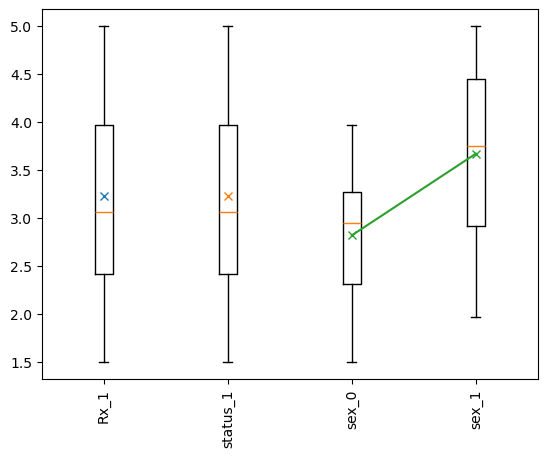

In [16]:
ave, dtr, pos, lab = effecttest(df[df["Rx"]==1], ["Rx", "status", "sex"], "logWBC")

### 性別での比較

Rx_0 Rx_1
t   = 0.111589
p   = 0.912261
val = 0.032727

status_0 status_1
t   = -1.075371
p   = 0.295011
val = -0.344375



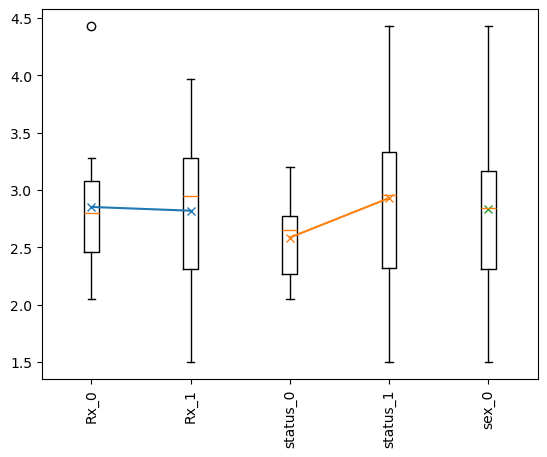

In [18]:
ave, dtr, pos, lab = effecttest(df[df["sex"]==0], ["Rx", "status", "sex"], "logWBC")

Rx_0 Rx_1
t   = -2.963402
p   = 0.008321
val = -1.271000

status_0 status_1
t   = -3.780679
p   = 0.001369
val = -1.611190



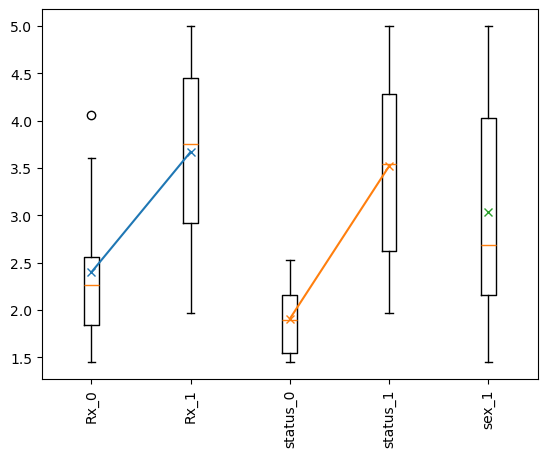

In [19]:
ave, dtr, pos, lab = effecttest(df[df["sex"]==1], ["Rx", "status", "sex"], "logWBC")

## 回帰分析
説明変数と目的変数が量的変数を想定する。

In [30]:
y = df["logWBC"]
x = df.drop("logWBC", axis=1)
y0 = df[df["Rx"]==0]["logWBC"]
x0 = df[df["Rx"]==0].drop("logWBC", axis=1)
y1 = df[df["Rx"]==1]["logWBC"]
x1 = df[df["Rx"]==1].drop("logWBC", axis=1)

### 多重共線性をVIFで考察

In [33]:
df_vif = pd.DataFrame(np.diag(np.linalg.inv(x.corr().values)))
df_vif.columns = ["VIF"]
df_vif.index = x.columns
df_vif.sort_values("VIF", ascending=False)

,VIF
status,1.938846
Rx,1.725318
t,1.552180
sex,1.061071


多重共線性が確認出来ない事が分かる。

In [36]:
x.corr()

,t,status,sex,Rx
t,1.000000,-0.544584,2.084431e-01,-4.563114e-01
status,-0.544584,1.000000,-3.015113e-02,6.324555e-01
sex,0.208443,-0.030151,1.000000e+00,-7.409893e-17
Rx,-0.456311,0.632456,-7.409893e-17,1.000000e+00


### 実際に回帰
重回帰分析を行う

In [39]:
model0 = sm.OLS(y0, x0).fit()
model0.summary()

C:\Users\decar\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1967: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 logWBC   R-squared (uncentered):                   0.813
Model:                            OLS   Adj. R-squared (uncentered):              0.781
Method:                 Least Squares   F-statistic:                              26.02
Date:                Fri, 20 Sep 2024   Prob (F-statistic):                    9.15e-07
Time:                        08:39:07   Log-Likelihood:                         -33.399
No. Observations:                  21   AIC:                                      72.80
Df Residuals:                      18   BIC:                                      75.93
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
t              0.1041      0.028      3.736      0.002       0.046       0.163
status         2.3877      0.473      5.047      0.000       1.394       3.382
sex           -1.1058      0.802     -1.379      0.185      -2.791       0.579
Rx                  0          0        nan        nan           0           0
==============================================================================
Omnibus:                        1.957   Durbin-Watson:                   1.733
Prob(Omnibus):                  0.376   Jarque-Bera (JB):                1.197
Skew:                           0.276   Prob(JB):                        0.550
Kurtosis:                       1.969   Cond. No.                          inf
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [41]:
model1 = sm.OLS(y1, x1).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 logWBC   R-squared:                       0.427
Model:                            OLS   Adj. R-squared:                  0.363
Method:                 Least Squares   F-statistic:                     6.698
Date:                Fri, 20 Sep 2024   Prob (F-statistic):            0.00669
Time:                        08:39:10   Log-Likelihood:                -22.854
No. Observations:                  21   AIC:                             51.71
Df Residuals:                      18   BIC:                             54.84
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
t             -0.0830      0.031     -2.664      0.016      -0.148      -0.018
status         1.8963      0.217      8.741      0.000       1.441       2.352
sex            0.3173      0.394      0.806      0.431      -0.510       1.145
Rx             1.8963      0.217      8.741      0.000       1.441       2.352
==============================================================================
Omnibus:                        2.141   Durbin-Watson:                   2.321
Prob(Omnibus):                  0.343   Jarque-Bera (JB):                1.678
Skew:                          -0.542   Prob(JB):                        0.432
Kurtosis:                       2.138   Cond. No.                     2.03e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.93e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## 説明変数が量的変数で目的変数が質的変数
判別分析をロジスティック回帰で行う

In [44]:
y = df["status"]
x = df.drop("status", axis=1)
model2 = sm.Logit(y, x).fit_regularized()
pred = model2.predict(x)
y_pred = np.where(pred >= 0.5, 1, 0)
print(classification_report(y, y_pred))
model2.summary()

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.21036007054621134
            Iterations: 54
            Function evaluations: 58
            Gradient evaluations: 54
              precision    recall  f1-score   support

           0       0.82      0.75      0.78        12
           1       0.90      0.93      0.92        30

    accuracy                           0.88        42
   macro avg       0.86      0.84      0.85        42
weighted avg       0.88      0.88      0.88        42



<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 status   No. Observations:                   42
Model:                          Logit   Df Residuals:                       38
Method:                           MLE   Df Model:                            3
Date:                Fri, 20 Sep 2024   Pseudo R-squ.:                  0.6484
Time:                        08:39:11   Log-Likelihood:                -8.8351
converged:                       True   LL-Null:                       -25.127
Covariance Type:            nonrobust   LLR p-value:                 3.941e-07
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
t             -0.3024      0.149     -2.025      0.043      -0.595      -0.010
sex            4.5153      2.699      1.673      0.094      -0.774       9.805
logWBC         0.9928      0.520      1.909      0.056      -0.027       2.012
Rx            23.8293   1.59e+04      0.001      0.999   -3.11e+04    3.12e+04
==============================================================================

Possibly complete quasi-separation: A fraction 0.50 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

### 決定木で分類過程を可視化する

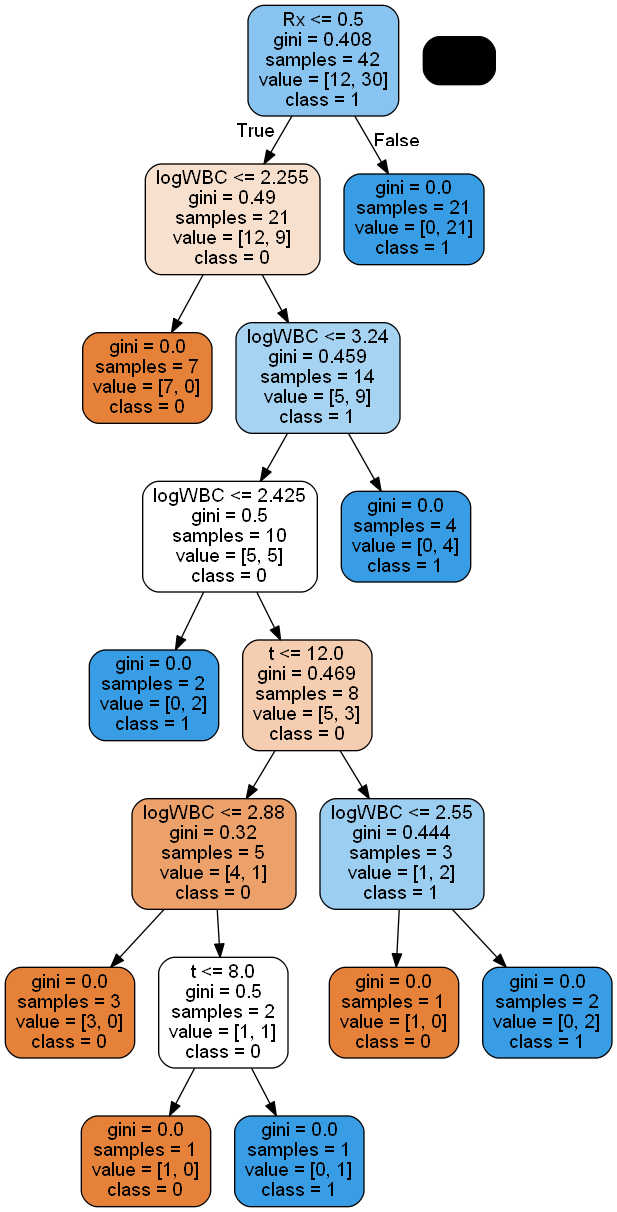

In [47]:
model3 = DecisionTreeClassifier()
model3.fit(x, y)
cn = list(set(y.values))
for i in range(len(cn)):
    cn[i] = str(cn[i])
dotdata = EG(model3, filled=True, rounded=True, class_names=cn, feature_names=x.columns, out_file=None)
graph = GFDD(dotdata)
graph.write_png("CART.png")
im = Image.open("CART.png")
im

In [48]:
df_imp = pd.DataFrame(model3.feature_importances_)
df_imp.columns = ["imp"]
df_imp.index = x.columns
df_imp

,imp
t,0.105972
sex,0.000000
logWBC,0.494028
Rx,0.400000


## ハザード分析
時間変数があるためこれを用いてCox比例ハザード分析を行う

In [52]:
model4 = CoxPHFitter()
model4.fit(df, duration_col="t", event_col="status")
model4.print_summary()

<lifelines.CoxPHFitter: fitted with 42 total observations, 12 right-censored observations>
             duration col = 't'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 42
number of events observed = 30
   partial log-likelihood = -69.59
         time fit was run = 2024-09-19 23:39:15 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
sex        0.31      1.37      0.45           -0.58            1.21                0.56                3.34
logWBC     1.68      5.38      0.34            1.02            2.34                2.78               10.40
Rx         1.50      4.50      0.46            0.60            2.41                1.82               11.11

           cmp to    z      p  -log2(p)
covariate                              
sex          0.00 0.69   0.49      1.03
logWBC       0.00 5.00 <0.005     20.71
Rx           0.00 3.26 <0.005      9.80
---
Concordance = 0.85
Partial AIC = 145.18
log-likelihood ratio test = 47.19 on 3 df
-log2(p) of ll-ratio test = 31.55

### 要約統計量を算出

In [55]:
df.drop(["t", "status"], axis=1).describe()

,sex,logWBC,Rx
count,42.000000,42.000000,42.000000
mean,0.476190,2.930238,0.500000
std,0.505487,0.917522,0.506061
min,0.000000,1.450000,0.000000
25%,0.000000,2.302500,0.000000
50%,0.000000,2.800000,0.500000
75%,1.000000,3.490000,1.000000
max,1.000000,5.000000,1.000000


算出された要約統計量から各変数のハザード比に与える効果をプロットする。

<Axes: >

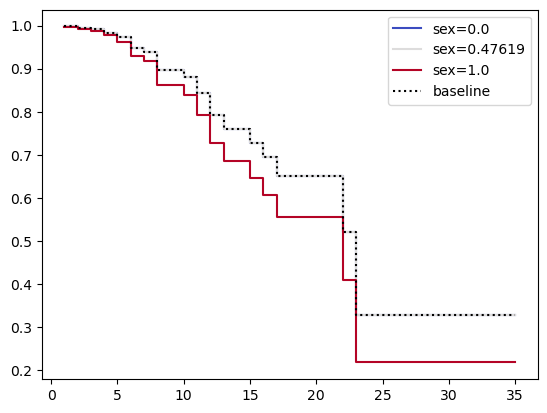

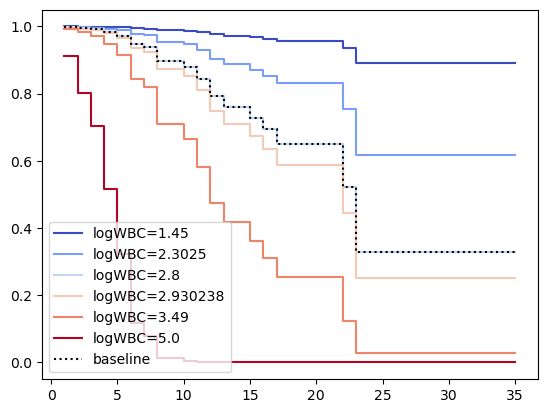

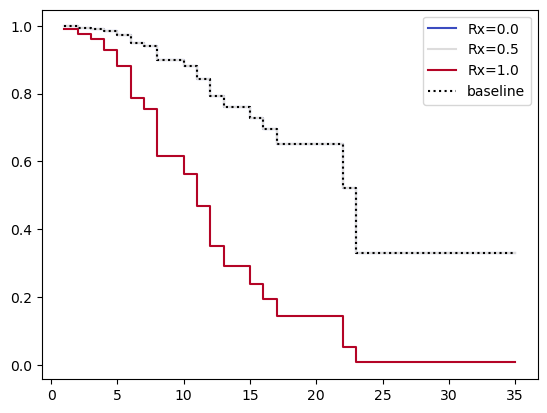

In [58]:
model4.plot_partial_effects_on_outcome(covariates="sex", values=[0, 0.476190, 1], cmap='coolwarm')
model4.plot_partial_effects_on_outcome(covariates="logWBC", values=[1.45, 2.3025, 2.8, 2.930238, 3.49, 5], cmap='coolwarm')
model4.plot_partial_effects_on_outcome(covariates="Rx", values=[0, 0.5, 1], cmap='coolwarm')

## 多次元データの可視化
biplotを用いて主成分分析で可視化する。

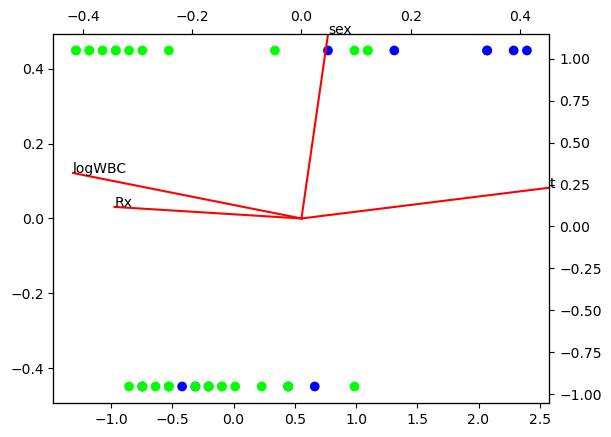

In [61]:
fig, ax = plt.subplots()
model5 = PCA()
ss = StandardScaler()
ss.fit(x)
tx = ss.transform(x)
model5.fit(tx)
evr = model5.explained_variance_ratio_
com = model5.components_
fac = []
for i in range(len(evr)):
    fac.append(np.sqrt(evr[i])*com[i])
ax1 = ax.twinx()
ax1.scatter(tx[:, 0], tx[:, 1], c=y, cmap="brg")
ax2 = ax.twiny()
xlim = [abs(min(fac[0])), abs(max(fac[0]))]
ylim = [abs(min(fac[1])), abs(max(fac[1]))]
for i in range(len(x.columns)):
    ax2.plot([0, fac[0][i]], [0, fac[1][i]], color="#FF0000")
    ax2.text(fac[0][i], fac[1][i], x.columns[i])
ax2.set_xlim(-max(xlim), max(xlim))
ax2.set_ylim(-max(ylim), max(ylim))
plt.show()